In [ ]:
print("Notebook is running!")

Notebook is running!


Let us showcase our Tox21 SR-MMP data in a more visual manner to make it easier for observation and analysis.

In [13]:
# Import all necessary packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, DataStructs

print(pd.__version__)

2.2.3


In [2]:
# Load the preprocessed Tox21 subset.
df = pd.read_csv('../data/tox21_sr-mmp.csv')

# Show the first rows.
df.head()

,smiles,toxicity
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0
2,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0
3,CC(O)(P(=O)(O)O)P(=O)(O)O,0
4,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0


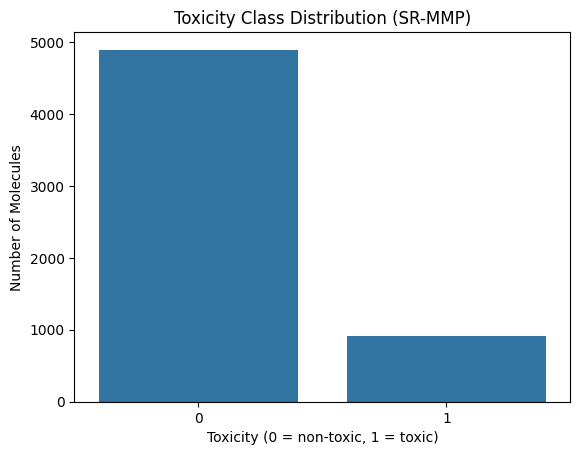

In [ ]:
# Visualize the class distribution of our Tox21 dataset (toxic vs non-toxic).
sns.countplot(x='toxicity', data=df)
plt.title('Toxicity Class Distribution (SR-MMP)')
plt.xlabel('Toxicity (0 = non-toxic, 1 = toxic)')
plt.ylabel('Number of Molecules')
plt.show()

In [7]:
# Convert SMILES to Mol objects.
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

# Calculate MolWt.
df['MolWt'] = df['mol'].apply(lambda m: Descriptors.MolWt(m) if m else None)

# Calculate hydrophobicity (LogP).
df['LogP'] = df['mol'].apply(lambda m: Descriptors.MolLogP(m) if m else None)

df[['smiles', 'toxicity', 'MolWt', 'LogP']].head()

[11:34:50] WARNING: not removing hydrogen atom without neighbors


,smiles,toxicity,MolWt,LogP
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0,258.324,1.34240
1,CCN1C(=O)NC(c2ccccc2)C1=O,0,204.229,1.29940
2,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0,276.424,3.75244
3,CC(O)(P(=O)(O)O)P(=O)(O)O,0,206.027,-0.99220
4,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0,290.444,4.81720


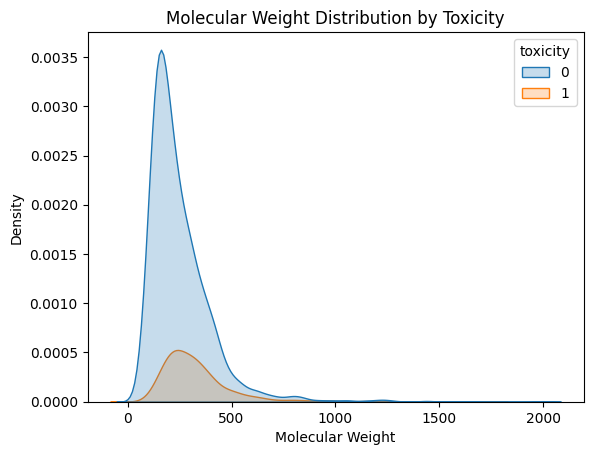

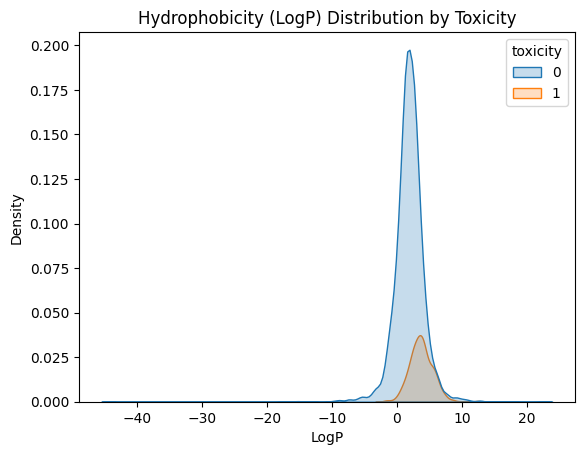

In [8]:
# Plot MolWt.
sns.kdeplot(data=df, x='MolWt', hue='toxicity', fill=True)
plt.title('Molecular Weight Distribution by Toxicity')
plt.xlabel('Molecular Weight')
plt.ylabel('Density')
plt.show()

# Plot LogP.
sns.kdeplot(data=df, x='LogP', hue='toxicity', fill=True)
plt.title('Hydrophobicity (LogP) Distribution by Toxicity')
plt.xlabel('LogP')
plt.ylabel('Density')
plt.show()

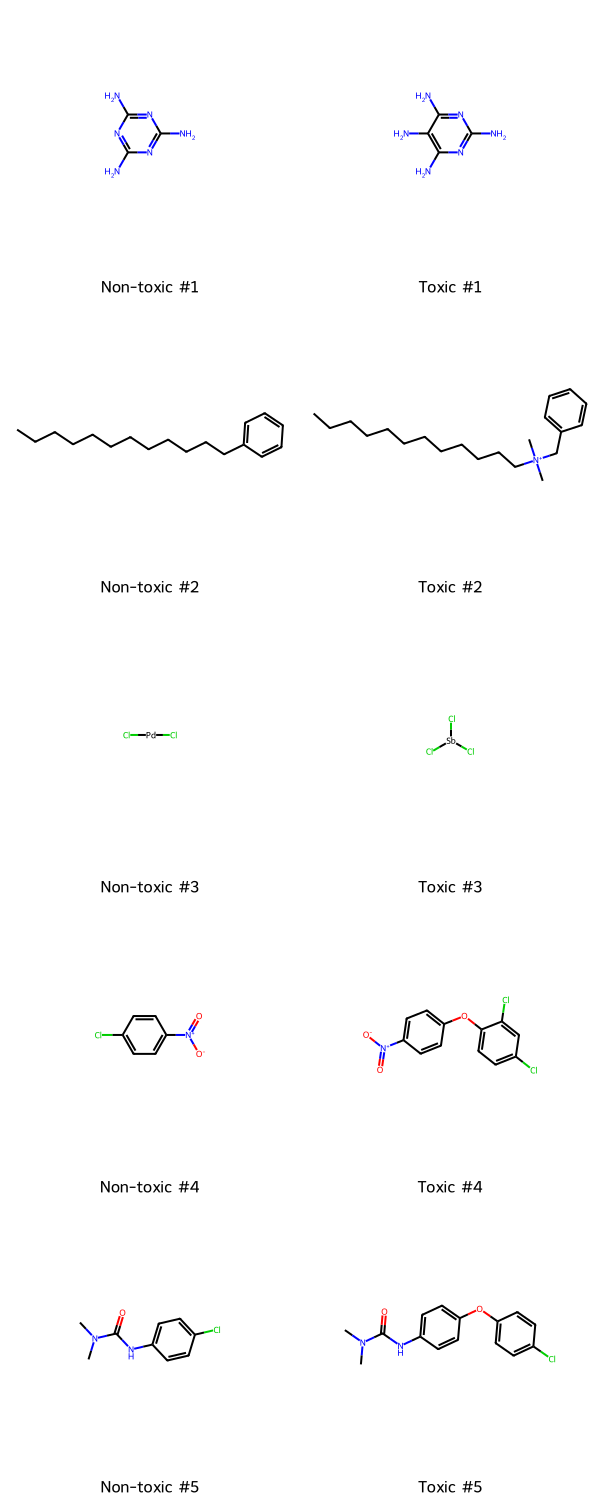

In [14]:
# Let's compare similar molecules in pairs of a toxic and a non-toxic molecule
# Filter and sample 5 toxic molecules.
toxic_samples = df[df['toxicity'] == 1].sample(5).copy()
nontoxic_pool = df[df['toxicity'] == 0].copy()

# Compute fingerprints.
def get_fp(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048) if mol else None

toxic_samples['fp'] = toxic_samples['mol'].apply(get_fp)
nontoxic_pool['fp'] = nontoxic_pool['mol'].apply(get_fp)

# Match each toxic molecule with its most similar non-toxic counterpart.
matched_nontoxic = []

for tox_fp in toxic_samples['fp']:
    # Compute similarities to all non-toxic molecules.
    similarities = nontoxic_pool['fp'].apply(lambda nt_fp: DataStructs.TanimotoSimilarity(tox_fp, nt_fp))
    most_similar_idx = similarities.idxmax()
    matched_nontoxic.append(nontoxic_pool.loc[most_similar_idx])

# Build the side-by-side grid: [non-toxic, toxic] x 5 rows.
mol_pairs = []

for nt, tox in zip(matched_nontoxic, toxic_samples.itertuples()):
    mol_pairs.extend([nt.mol, tox.mol])

legends = []

for i in range(len(toxic_samples)):
    legends.extend([f"Non-toxic #{i+1}", f"Toxic #{i+1}"])

# Display as a 2-column grid.
Draw.MolsToGridImage(mol_pairs, molsPerRow=2, legends=legends, subImgSize=(300,300))

In [16]:
# We can also print them in SMILES for a text table.
for i, (nt, tox) in enumerate(zip(matched_nontoxic, toxic_samples.itertuples())):
    print(f"Pair {i+1}:")
    print("  Non-toxic:", nt.smiles)
    print("     Toxic:", tox.smiles)
    print()

Pair 1:
  Non-toxic: Nc1nc(N)nc(N)n1
     Toxic: Nc1nc(N)c(N)c(N)n1

Pair 2:
  Non-toxic: CCCCCCCCCCCCc1ccccc1
     Toxic: CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1

Pair 3:
  Non-toxic: Cl[Pd]Cl
     Toxic: Cl[Sb](Cl)Cl

Pair 4:
  Non-toxic: O=[N+]([O-])c1ccc(Cl)cc1
     Toxic: O=[N+]([O-])c1ccc(Oc2ccc(Cl)cc2Cl)cc1

Pair 5:
  Non-toxic: CN(C)C(=O)Nc1ccc(Cl)cc1
     Toxic: CN(C)C(=O)Nc1ccc(Oc2ccc(Cl)cc2)cc1

